![Riga](https://europa.eu/youth/sites/default/files/article/riga-panorama-latvia-travel_0.jpg)

# Introduction
[Riga](https://en.wikipedia.org/wiki/Riga) is a lovely city near the Baltic Sea, the capital of Latvia. 


This kernel is written for the Riga Data Science Club - an international community of data scientists based in Riga and Slack 😃
We will be happy to accept people from all over the world to join our friendly chat. It is totally free. Please sign up here: [http://rigadsclub.com/join-us/](http://rigadsclub.com/join-us/)

Yours,
Riga DS Club

# Previous work

In the previous [kernel](https://www.kaggle.com/dmitryyemelyanov/riga-real-estate-data-cleaning-riga-ds-club) we have explored [original Riga Real Estate dataset](https://www.kaggle.com/trolukovich/riga-real-estate-dataset) and applied some data cleaning techniques. This kernel aims to proceed on the [cleaned dataset](https://www.kaggle.com/dmitryyemelyanov/riga-real-estate-dataset-cleaned) and is focused on choosing most efficient ML model to predict real estate price.


# Data exploration

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/kaggle/input/riga-real-estate-dataset-cleaned/riga.csv')
df.head(5)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350
2,For sale,centrs,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884
3,For sale,Ķengarags,Maskavas 305,2,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,56.859788,24.308342
4,For rent,Teika,Zemgala gatve 80,3,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,56.977745,24.166042


Let's check value counts for **op_type** column that describes real estate operation type:

In [2]:
df.op_type.value_counts()

For sale    2650
For rent    1507
Name: op_type, dtype: int64

As both operations have quite a large number of samples, we have two design options:
*  Build general model that predicts price for both operations and takes op_type as one of the inputs
*  Split dataset into distinct "Sale" and "Rent" datasets to build separate "Sale" and "Rent" models

Next, let's review how balanced our dataset is in terms of real estate property location:

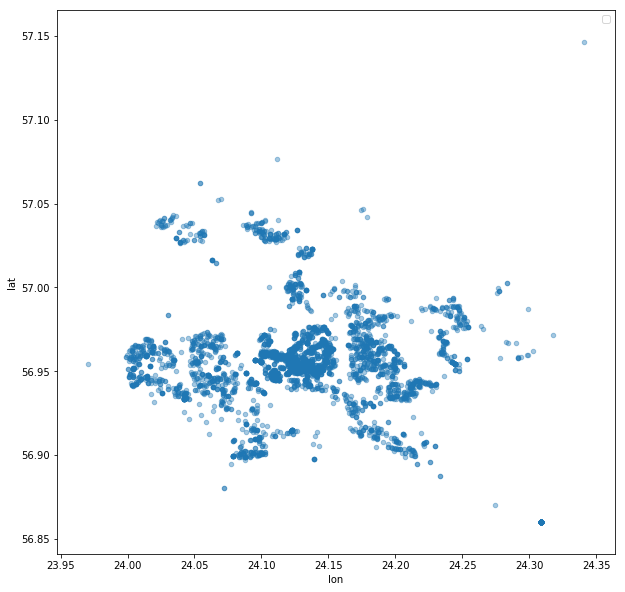

In [3]:
viz = df.plot(kind='scatter', x='lon', y='lat', alpha=0.4, figsize=(10,10))
viz.legend()

It seems we have more samples coming from the city center, while having other districts represented with fewer number of samples. Let's check that:

In [4]:
df.district.value_counts()

centrs                    1373
Purvciems                  323
Āgenskalns                 227
Ziepniekkalns              197
Imanta                     196
Ķengarags                  191
Pļavnieki                  187
Teika                      124
Mežciems                   112
Vecrīga                    107
Iļģuciems                  106
Vecmīlgrāvis               103
Jugla                       95
Zolitūde                    90
Sarkandaugava               87
Maskavas priekšpilsēta      67
Šampēteris-Pleskodāle       67
Mežaparks                   50
Dzegužkalns                 48
Bolderāja                   45
Dārzciems                   43
Čiekurkalns                 38
Krasta r-ns                 36
Grīziņkalns                 29
Torņakalns                  28
Klīversala                  27
Ķīpsala                     27
Daugavgrīva                 26
Mangaļi                     22
Šķirotava                   15
Aplokciems                  12
Zasulauks                    9
Jaunciem

In order to get consistent model performance across all Riga districts, we will define a resample function that downsamples central district and upsamples other districts.

In [5]:
from sklearn.utils import resample

# Helper method to upsample dataset to have equal sample count per district
def resample_by_district(df):
    df_result = pd.DataFrame(columns=df.columns)
    n_samples = np.minimum(df.district.value_counts()['centrs'], 500)
    for district in df.district.unique():
        df_district = df[df['district'] == district]
        df_resampled = resample(df_district, 
                             replace=True,
                             n_samples=n_samples)
        df_result = pd.concat([df_result, df_resampled])
    return df_result
    
# Verifying that it works
resample_by_district(df)['district'].value_counts()

Kleisti                   500
Bolderāja                 500
Vecmīlgrāvis              500
Daugavgrīva               500
Valdlauči                 500
Ziepniekkalns             500
Mežaparks                 500
Teika                     500
Torņakalns                500
Mangaļsala                500
Zasulauks                 500
Ķīpsala                   500
Kundziņsala               500
Grīziņkalns               500
Vecdaugava                500
Pļavnieki                 500
Dārzciems                 500
Dreiliņi                  500
Sarkandaugava             500
Jaunciems                 500
Vecrīga                   500
Jaunmīlgrāvis             500
Brekši                    500
Vecāķi                    500
Šampēteris-Pleskodāle     500
Voleri                    500
Jugla                     500
Āgenskalns                500
Čiekurkalns               500
VEF                       500
Purvciems                 500
Klīversala                500
Iļģuciems                 500
Krasta r-n

Please note we will not use this function immediately - resampling will be applied for training set only upon dataset split.

# Splitting the data
Dataset will be split into train, validation, and test sets.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
def print_df_info(df_train, df_test, df_val):
    print(len(df_train), 'train examples')
    print(len(df_test), 'validation examples')
    print(len(df_val), 'test examples')

In [8]:
df_sale = df[df['op_type'] == 'For sale']
# Final cleanup
df_sale_clean = df_sale[(df_sale.price < 300000) & (df_sale.area <160)  
                  & (~((df_sale.price < 50000) &(df_sale.area > 80))) 
                 & (~((df_sale.price < 100000)&(df_sale.area > 130)))
                 ].copy()

df_sale_train, df_sale_test = train_test_split(df_sale_clean, test_size=0.1)
df_sale_train, df_sale_val = train_test_split(df_sale_train, test_size=0.1)
#df_sale_train = resample_by_district(df_sale_train)
dfs_sale = [df_sale_train, df_sale_val, df_sale_test]
print("For sale:")
print_df_info(*dfs_sale)

For sale:
2050 train examples
228 validation examples
254 test examples


In [9]:
df_rent = df[df['op_type'] == 'For rent']
# Final cleanup
df_rent_clean = df_rent[(df_rent.price < 1390) & (df_rent.area <125) & (df_rent.price > 60) 
                  & (~((df_rent.price < 110) &(df_rent.area > 40))) 
                 & (~((df_rent.price < 400)&(df_rent.area > 100)))
                  & (~((df_rent.price > 1000)&(df_rent.area < 70)))
                 ].copy()

df_rent_train, df_rent_test = train_test_split(df_rent_clean, test_size=0.1)
df_rent_train, df_rent_val = train_test_split(df_rent_train, test_size=0.1)
#df_rent_train = resample_by_district(df_rent_train)
dfs_rent = [df_rent_train, df_rent_val, df_rent_test]
print("For rent:")
print_df_info(*dfs_rent)

For rent:
1033 train examples
115 validation examples
128 test examples


In [10]:
df_all_clean = pd.concat([df_sale_clean, df_rent_clean])
df_all_train, df_all_test = train_test_split(df_all_clean, test_size=0.1)
df_all_train, df_all_val = train_test_split(df_all_train, test_size=0.1)
#df_all_train = resample_by_district(df_all_train)
dfs_all = [df_all_train, df_all_test, df_all_val]
print("All:")
print_df_info(*dfs_all)

All:
3084 train examples
381 validation examples
343 test examples


Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. 

In [11]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def input_fn(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size)


def get_input_data_sets(batch_size, df_train, df_val, df_test):
    train_ds = input_fn(df_train, batch_size=batch_size)
    val_ds = input_fn(df_val, shuffle=False, batch_size=batch_size)
    test_ds = input_fn(df_test, shuffle=False, batch_size=batch_size)
    return [train_ds, val_ds, test_ds]

# Feature engineering
In this notebook we are using TensoFlow feature columns, that enable transformation of raw column values into TensorFlow model input in a friendly way for further model training. You can find more on this topic in this great [TensorFlow tutorial](https://www.tensorflow.org/tutorials/structured_data/feature_columns).

In [12]:
# Importing dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import feature_column
from tensorflow.keras import layers

In [13]:
# Initializing array to store feature columns
feature_columns = []

We will start by adding most simple columns representing numeric values:

In [14]:
# Create numeric columns
for header in ['rooms', 'floor', 'total_floors']:
    feature_columns.append(feature_column.numeric_column(header))

Let's bucketize area, as we are mostly interested in some levels of property area instead of exact values:

In [15]:
# Create bucketized columns
area = feature_column.numeric_column("area")
#area_boundaries = list(np.arange(start=25, stop=df['area'].max(), step = 10))
area_boundaries = [25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, 105.0, 115.0, 125.0, 155.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0]
area_buckets = feature_column.bucketized_column(area, boundaries=area_boundaries)
feature_columns.append(area_buckets)
print("Area boundaries", area_boundaries)

Area boundaries [25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, 105.0, 115.0, 125.0, 155.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0]


Categorical columns will be added using one-hot encoding:

In [16]:
# Create categorical one-hot encoded columns
categorical_headers = ['op_type', 'house_seria', 'house_type', 'condition']
for header in categorical_headers:
    categorical = feature_column.categorical_column_with_vocabulary_list(header, df[header].unique())
    feature_columns.append(feature_column.indicator_column(categorical))

District might be treated separately, as it has quite large count of unique values. Let's check it out:

In [17]:
# Evaluate district vocabulary
len(df.district.unique())

48

In case vocabulary of any categorical value is large, it might be problematic to train a neural network using one-hot encodings due to large dimensions of the one-hot matrix. TensorFlow provides some extra feature columns to lower the dimensions of the input:
* embedding_column
* categorical_column_with_hash_bucket

Model evaluation has shown that we are fine with simple one-hot encoding for districts, so other options are commented out and left for your information:

In [18]:
# Create categorical representation for district
district = feature_column.categorical_column_with_vocabulary_list('district', df.district.unique())

# Option 1: Use indicator_column to create one-hot encoding:
feature_columns.append(feature_column.indicator_column(district))

# Option 2: Use embedding_column to reduce dimensions of encoding:
# district_embedding = feature_column.embedding_column(district, dimension=8)
# feature_columns.append(district_embedding)

# Option 3: Use categorical_column_with_hash_bucket to reduce dimensions of encoding:
# This feature column calculates a hash value of the input, then selects one of the hash_bucket_size buckets to encode a string. 
# district_hashed = feature_column.categorical_column_with_hash_bucket('district', hash_bucket_size=1000)

What about geolocation? In our use case treating latitude and longitude independently is highly inefficient, as the real location is a concatenation of them both. Combining several features into a single one is known as **feature crosses**. This enables a model to learn separate weights for each combination of features. Let's build a feature cross for latitude and longitude.

In [19]:
# Create numeric columns first
feature_lat = feature_column.numeric_column("lat")
feature_lon = feature_column.numeric_column("lon")

Crossed column can't be created directly from the numeric one, so we will bucketize numeric columns first. This is extremely useful approach for geolocation scenario - you may think of it as splitting the map into tiles and make model learn weights for each tile independently.

Number of tiles to use depends on the "resolution" we will fine-tune to get best model performance.

In [20]:
# Helper method to calculate equidistant coordinates on a single coordinate axis
# "axis_key" is either "lat" or "lon"
# "n_coords" is representing "resolution" that will affect tile size and density
def get_equidistant_coords(axis_key, n_coords):
    geo_min = df[axis_key].min()
    geo_max = df[axis_key].max()
    geo_range = geo_max - geo_min
    geo_step = geo_range / n_coords
    return np.arange(geo_min, geo_max, geo_step).tolist()


# Constructs a grid of equidistant points of required "resolution"
def get_equidistant_points(n_coords):
    latitudes = get_equidistant_coords('lat', n_coords)
    longitudes = get_equidistant_coords('lon', n_coords)
    xv, yv = np.meshgrid(latitudes, longitudes, sparse=False, indexing='ij')
    points = []
    for i in range(n_coords):
        for j in range(n_coords):
            points.append([xv[i,j], yv[i,j]])
            
    return points

# Checking how it works
print("Equidistant longitudes:", get_equidistant_coords("lon", 2))
print("Equidistant latitudes:", get_equidistant_coords("lat", 2))
print("Equidistant point grid:", get_equidistant_points(2))

Equidistant longitudes: [23.9702807, 24.1555732]
Equidistant latitudes: [56.8597884, 57.00315165]
Equidistant point grid: [[56.8597884, 23.9702807], [56.8597884, 24.1555732], [57.00315165, 23.9702807], [57.00315165, 24.1555732]]


This allows us to cover Riga with tiles of arbitrary density and use these coordinates to feature engineer best possible lat-lon crossed feature column. Let's define some more helper functions to proceed:

In [21]:
import folium

# Constructs helper method to convert point to rect
def get_point_to_rect(n_tiles):
    dx = (df['lat'].max() - df['lat'].min()) / n_tiles
    dy = (df['lon'].max() - df['lon'].min()) / n_tiles
    def point_to_rect(x,y):
        return [
            [x,y],
            [x+dx, y],
            [x+dx, y+dy],
            [x, y+dy]
        ]
    return point_to_rect
    
# Helper method to get tile grid
def get_tiles(n_tiles):
    points = get_equidistant_points(n_tiles)
    point_to_rect = get_point_to_rect(n_tiles)
    return list(map(lambda point: point_to_rect(*point), points))

# Helper method to visualize coordinate tiles over Riga map
def plot_tiles(tiles): 
    tiles_map = folium.Map(
        location=[56.946285, 24.105078],
        tiles='cartodbpositron',
        zoom_start=11,
    )
    for points in tiles:
        folium.Rectangle(bounds=points, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(tiles_map)
        
    return tiles_map

In [22]:
# Visualize tiles to get the intuition how well they fit Riga coordinates
n_tiles = 2
tiles = get_tiles(n_tiles)
plot_tiles(tiles)

In [23]:
# Checking out higher tile density
n_tiles = 20
tiles = get_tiles(n_tiles)
plot_tiles(tiles)

Visualization helps to find out some weak sides of this feature engineering approach:
*  some of the tiles are placed over the sea or outside the city borders
*  difference in population and real estate density is not taken into account

More optimal approach would be to have different-sized tile grid depending on real estate density and price variance accross coordinate axis. We should also take into account real shape of Riga borders. Let's fix this!

In [24]:
import json

# Load Riga boundaries 
with open("/kaggle/input/riga-city-boundaries-geojson/riga_boundaries_polygon.json") as f:
    geometry_collection = json.load(f)
    riga_boundaries = geometry_collection['geometries'][0]


In [25]:
from shapely.geometry import shape, Point

# Helper function to check whether point is fitting Riga borders
def is_within_riga_boundaries(y, x):
    for polygon in shape(riga_boundaries):
        if Point(x,y).within(polygon):
            return True
    return False

# Verify that it's working by checking Riga center point
is_within_riga_boundaries(56.946285, 24.105078)

True

In [26]:
from shapely.geometry import Point

# Helper method to get tiles fitting Riga boundaries
def get_tiles_within_riga_boundaries(n_tiles):
    points = get_equidistant_points(n_tiles)
    points_filtered = list(filter(lambda point: is_within_riga_boundaries(*point), points))
    point_to_rect = get_point_to_rect(n_tiles)
    return list(map(lambda point: point_to_rect(*point), points_filtered))

In [27]:
# Comparing results between original and improved approach
original_tiles = get_tiles(30)
filtered_tiles = get_tiles_within_riga_boundaries(30)
print("Original tile count:", len(original_tiles))
print("Filtered tile count:", len(filtered_tiles))

Original tile count: 900
Filtered tile count: 373


Quite impressive improvement! We now have 3 times less features for bucket-encoded geo coordinates if we use tile density of 30 per-axis. 

In [28]:
# Checking result on the map
plot_tiles(filtered_tiles)

Now we are ready to create buckets out of tiled latitude and longitude values. This time we will not plot them, as such increased tile density is producing quite a heavy load on CPU.

In order to create a crossed column, we have to follow a pipeline:
1. Create numeric columns for lat and lon
2. Create bucketized columns out of created numeric columns
3. Create a crossed column out of bucketized columns

Out of three steps we will add to our final **feature_columns** array only the crossed column.

In [29]:
# Optimal tile density
n_tiles = 50
# Grid of points
points = get_equidistant_points(n_tiles)
# Points fitting Riga boundaries
points_filtered = list(filter(lambda point: is_within_riga_boundaries(*point), points))
# Getting back to separate lists
latitudes, longitudes = zip(*points_filtered)
# Getting back to unique sorted values
latitude_boundaries = list(set(latitudes))
longitude_boundaries = list(set(longitudes))
latitude_boundaries.sort()
longitude_boundaries.sort()

# Numeric columns required to initialize bucketized columns later
feature_lat = feature_column.numeric_column('lat')
feature_lon = feature_column.numeric_column('lon')

#latitude_boundaries = get_equidistant_coords('lat', n_tiles)
#longitude_boundaries = get_equidistant_coords('lon', n_tiles)
# Bucketize longitude and latitude using numeric columns and calculated boundaries
bucketized_lat = feature_column.bucketized_column(feature_lat, boundaries=latitude_boundaries)
bucketized_lon = feature_column.bucketized_column(feature_lon, boundaries=longitude_boundaries)


# Create a crossed column from the bucketized values
crossed_geo = feature_column.crossed_column([bucketized_lat, bucketized_lon], hash_bucket_size=n_tiles*n_tiles)
crossed_geo = feature_column.indicator_column(crossed_geo)
feature_columns.append(crossed_geo)

Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is by tuning **hash_bucket_size**.

# Neural network model

We will evaluate two neural network models: shallow one and the deep one. In order to reduce overfitting we will add dropout and early stopping.

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import DenseFeatures, Dense, Dropout

In [31]:
kernel_initializer='he_uniform'

TensorFlow provides DenseFeatures layer that produces a dense Tensor based on given **feature_columns**. This way we can create input layer for our model very easily.

In [32]:
def create_shallow_model():
    model = Sequential()

    #Input Layer
    model.add(DenseFeatures(feature_columns))

    #Hidden Layers
    model.add(Dense(128, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer=kernel_initializer, activation='relu'))
    #Output Layer
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation='relu'))

    return model


In [33]:
def create_deep_model():
    model = Sequential()

    #Input Layer
    model.add(DenseFeatures(feature_columns))
    
    #Hidden Layers
    model.add(Dense(512, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(32, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(16, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(8, kernel_initializer=kernel_initializer, activation='relu'))
    
    #Output Layer
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation='relu'))

    return model

In [34]:
# Helper method to evaluate model performance on different dataset combinations (all rows / sale-only rows / rent-only rows)
def compile_train_evaluate(model, min_delta, train_ds, val_ds, test_ds):
    model.compile(
      loss=tf.keras.losses.MeanAbsoluteError(), 
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9), 
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=min_delta, patience=20,verbose=1)
    ]
    history = model.fit(train_ds,
              validation_data=val_ds,
              callbacks=callbacks,
              epochs=150,
              verbose=0)
    loss, mae = model.evaluate(test_ds) 
    return [history, mae]

In [35]:
batch_sizes = [16, 64]
model_names = ['Shallow', 'Deep']
model_creators = [lambda: create_shallow_model(), lambda: create_deep_model()]
dataframe_names = ['Rent', 'Sale', 'All']
dataframes = [dfs_rent, dfs_sale, dfs_all]

models = {}
histories = {}
results = {}

for i, dfs in enumerate(dataframes, start=0):
    df_name = dataframe_names[i]
    for j, create_model in enumerate(model_creators, start=0):
        model_name = model_names[j]
        for batch_size in batch_sizes:
            key = "[model=" + model_name + "][dataframe=" +  df_name + "][batch_size=" + str(batch_size) + "]"
            models[key] = create_model()
            datasets = get_input_data_sets(batch_size, *dfs)
            # Different early stopping parameters for "Rent-only" dataset
            min_delta = 5 if "Rent" in key else 100
            print('Evaluating configuration: ' + key)
            history, mae = compile_train_evaluate(models[key], min_delta, *datasets)
            results[key] = mae
            histories[key] = history

Evaluating configuration: [model=Shallow][dataframe=Rent][batch_size=16]
Epoch 00042: early stopping
8/8 [==============================] - 0s 3ms/step - loss: 63.7056 - mean_absolute_error: 63.7056
Evaluating configuration: [model=Shallow][dataframe=Rent][batch_size=64]
Epoch 00044: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 64.9506 - mean_absolute_error: 64.9506
Evaluating configuration: [model=Deep][dataframe=Rent][batch_size=16]
Epoch 00035: early stopping
8/8 [==============================] - 0s 4ms/step - loss: 67.2803 - mean_absolute_error: 67.2803
Evaluating configuration: [model=Deep][dataframe=Rent][batch_size=64]
Epoch 00038: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 67.7537 - mean_absolute_error: 67.7537
Evaluating configuration: [model=Shallow][dataframe=Sale][batch_size=16]
Epoch 00132: early stopping
16/16 [==============================] - 0s 3ms/step - loss: 13499.7667 - mean_absolute_error: 13509.8086
Eva

In [36]:
# Check all results
results

{'[model=Shallow][dataframe=Rent][batch_size=16]': 63.70558,
 '[model=Shallow][dataframe=Rent][batch_size=64]': 64.950584,
 '[model=Deep][dataframe=Rent][batch_size=16]': 67.28035,
 '[model=Deep][dataframe=Rent][batch_size=64]': 67.75369,
 '[model=Shallow][dataframe=Sale][batch_size=16]': 13509.809,
 '[model=Shallow][dataframe=Sale][batch_size=64]': 14065.849,
 '[model=Deep][dataframe=Sale][batch_size=16]': 15739.714,
 '[model=Deep][dataframe=Sale][batch_size=64]': 83009.43,
 '[model=Shallow][dataframe=All][batch_size=16]': 8702.149,
 '[model=Shallow][dataframe=All][batch_size=64]': 8934.412,
 '[model=Deep][dataframe=All][batch_size=16]': 9971.05,
 '[model=Deep][dataframe=All][batch_size=64]': 9286.412}

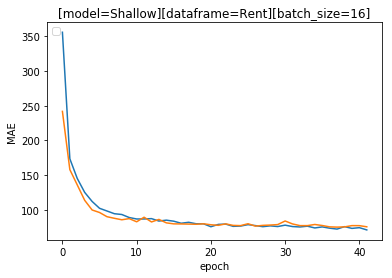

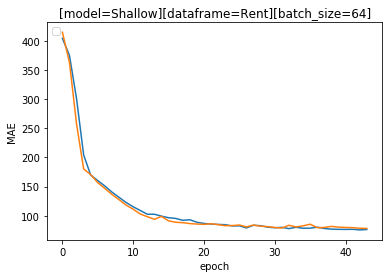

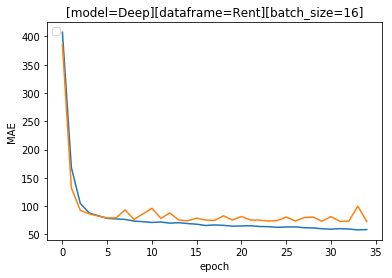

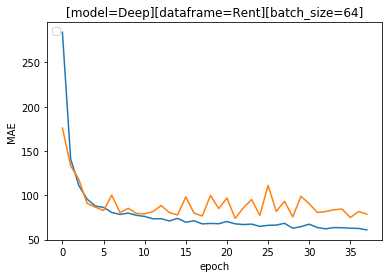

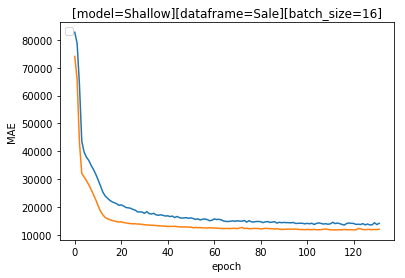

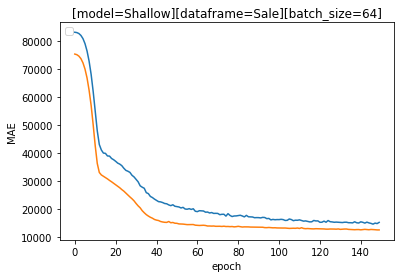

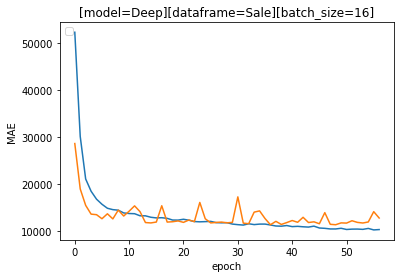

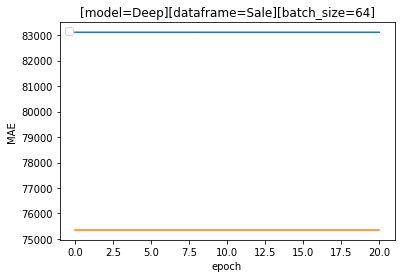

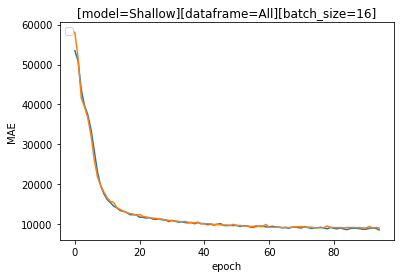

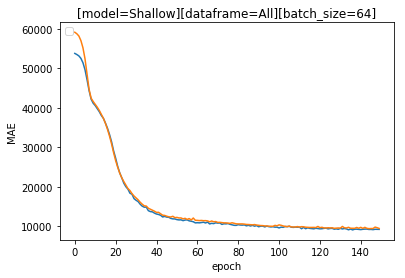

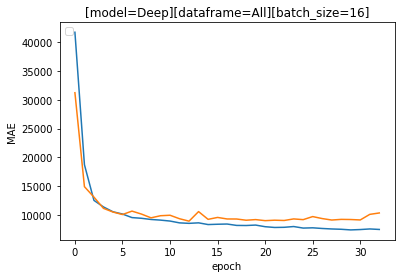

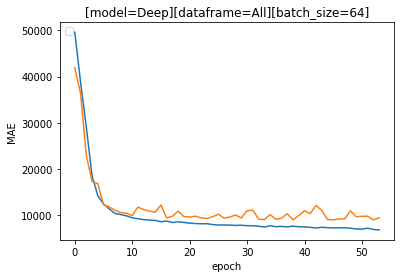

In [37]:
figure, axes = plt.subplots(nrows=0, ncols=len(histories))
def plot_mae(history, name):
    plt.title(name)
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.show()

for name, history in histories.items():
    plot_mae(history, name) 

# Verification on the real samples

It is always enjoyable to see machine learning performing on the real-world data, so I have kindly asked my friend to disclose information on his flat located in Riga for the sake of data science:
* Discrict: Teika
* Number of rooms: 3
* Area: 75.3 m2
* Floor: 3
* Total floors: 3
* House seria: Staļina
* House type: Brick
* Location: 56.967406° N 24.186564° E
* Actual purchase price: 72 000 EUR

Let's compare it with the price predicted by the model!


In [38]:
def get_test_property(op_type):
    return {
        'op_type': [op_type],
        'district': ['Teika'],
        'street': [''],
        'rooms': [3],
        'area': [75.3],
        'floor': [3],
        'total_floors': [3],
        'house_seria': ['Staļina'],
        'house_type': ['Brick'],
        'condition': ['All amenities'],
        'lat': [56.967406], 
        'lon': [24.186564],
        'price': [0]
    }

In [39]:
# Helper method to prepare single real estate object to be fed into model
# As model was trained using batches, in order to make a single prediction we have feed it with the data of the same batch size
# Please let me know if there is more elegant way to do this
def create_test_ds(batch_size, real_estate_object):
    test_df = pd.DataFrame.from_dict(real_estate_object)
    # Creating input of the same batch size as model was trained on
    test_df.append([real_estate_object]*(batch_size-1),ignore_index=True)
    return input_fn(test_df, shuffle=False, batch_size=batch_size)

In [40]:
rent_test_ds = create_test_ds(64, get_test_property('For rent'))

for key in models.keys():
    if "Rent" in key or "All" in key:
        print("Rent prediction:", models[key].predict(rent_test_ds)[0][0], "EUR by", key)

Rent prediction: 574.9623 EUR by [model=Shallow][dataframe=Rent][batch_size=16]
Rent prediction: 597.3987 EUR by [model=Shallow][dataframe=Rent][batch_size=64]
Rent prediction: 514.3082 EUR by [model=Deep][dataframe=Rent][batch_size=16]
Rent prediction: 545.7301 EUR by [model=Deep][dataframe=Rent][batch_size=64]
Rent prediction: 430.09195 EUR by [model=Shallow][dataframe=All][batch_size=16]
Rent prediction: 323.2499 EUR by [model=Shallow][dataframe=All][batch_size=64]
Rent prediction: 446.24814 EUR by [model=Deep][dataframe=All][batch_size=16]
Rent prediction: 446.3839 EUR by [model=Deep][dataframe=All][batch_size=64]


In [41]:
sale_test_ds = create_test_ds(64, get_test_property('For sale'))

for key in models.keys():
    if "Sale" in key or "All" in key:
        print("Sale prediction:", models[key].predict(sale_test_ds)[0][0], "EUR by", key)

Sale prediction: 98192.1 EUR by [model=Shallow][dataframe=Sale][batch_size=16]
Sale prediction: 98132.98 EUR by [model=Shallow][dataframe=Sale][batch_size=64]
Sale prediction: 82855.13 EUR by [model=Deep][dataframe=Sale][batch_size=16]
Sale prediction: 0.0 EUR by [model=Deep][dataframe=Sale][batch_size=64]
Sale prediction: 97819.88 EUR by [model=Shallow][dataframe=All][batch_size=16]
Sale prediction: 96347.47 EUR by [model=Shallow][dataframe=All][batch_size=64]
Sale prediction: 81991.836 EUR by [model=Deep][dataframe=All][batch_size=16]
Sale prediction: 88877.29 EUR by [model=Deep][dataframe=All][batch_size=64]


In [42]:
# Save all models
    for key in models.keys():
        models[key].save(key + '.h5')